In [44]:
from numpyro.distributions import constraints
import jax
import jax.numpy as np
import numpyro.distributions as dist
import numpyro
from numpyro.distributions.util import logsumexp
from numpyro.infer.stein import SVGD
from numpyro.infer.kernels import RBFKernel
from numpyro.contrib.autoguide import AutoDelta, AutoContinuousELBO
from numpyro.infer.util import init_with_noise, init_to_value
from numpyro.optim import Adam
from numpyro.infer import ELBO
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
class DualMoonDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(DualMoonDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return np.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        term1 = 0.5 * ((np.linalg.norm(x, axis=-1) - 2) / 0.4) ** 2
        term2 = -0.5 * ((x[..., :1] + np.array([-2., 2.])) / 0.6) ** 2
        pe = term1 - logsumexp(term2, axis=-1)
        return -pe


def dual_moon_model():
    numpyro.sample('x', DualMoonDistribution())

In [52]:
rng_key = jax.random.PRNGKey(142)

guide = AutoDelta(dual_moon_model, init_strategy=init_with_noise(init_to_value({'x': np.array([0.,0.])}), noise_scale=1.0))

svgd = SVGD(dual_moon_model, guide, Adam(step_size=1e-4), AutoContinuousELBO(),
            RBFKernel(mode='vector'), num_stein_particles=1000, num_loss_particles=100)
svgd_state = svgd.init(rng_key)

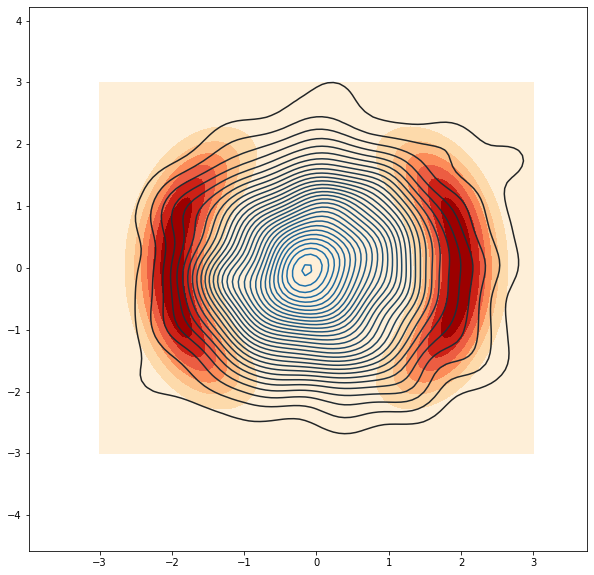

In [53]:
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
P = np.exp(DualMoonDistribution().log_prob(np.stack([X1, X2], axis=-1)))

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.contourf(X1, X2, P, cmap='OrRd', )
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1], n_levels=30, ax=ax)
